# ImageNet Benchmark

Notes on evaluation:

* Each unique experiment can be identified by looking at the `train_kwargs` parameter.
    * Standard PyTorch sampling occurs when `{"sampler": False}`
    * Datasetq Heapq sampling occurs when `{"sampler": True}`
* Each unique experiment is conducted using a single seed (resource and time constraints) with per epoch data shuffling. 
    
    
> Disclaimer: This notebook is kind of long but should be straightforward...

In [1]:
import pandas as pd
import torch
from torchvision import datasets, transforms

from index2class import idx2cls

In [2]:
import sys

sys.path.append("../")

import summary

In [3]:
metrics = [
    "loss",
    "top1_accuracy",
    "top5_accuracy",
    "time",
]

## 1. ImageNet Experiment

In [4]:
dataset = ""
experiment_name = "imagenet_results"

In [5]:
topk = 25
index = 0

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

unnormalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
)

### A. Train

In [7]:
arg_file = "args.json"
csv_file = "train_cache_map.csv"
model_file = "model.pth"

In [8]:
train_dataset = datasets.ImageFolder(
    "imagenet/train",
    transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]
    ),
)

#### i. Load data

In [9]:
hist_paths = summary.get_paths(csv_file, dataset, experiment_name)
arg_paths = summary.get_paths(arg_file, dataset, experiment_name)
model_paths = summary.get_paths(model_file, dataset, experiment_name)

In [10]:
hist_path = hist_paths[index]
arg_path = arg_paths[index]
model_path = model_paths[index]

In [11]:
hist = pd.read_csv(hist_path)
arg = summary.json_load(arg_path)
model = torch.load(model_path)

In [12]:
hist_visits = hist.sort_values(by=["visits"], ascending=False)
hist_loss = hist.sort_values(by=["loss"], ascending=False)

In [13]:
print(arg)

{'dataset': 'imagenet', 'arch': 'resnet18', 'train_kwargs': {'batch_size': 256, 'sampler': True, 'steps': 1, 'shuffle': True}, 'test_kwargs': {'batch_size': 256, 'sampler': True, 'steps': 1, 'shuffle': False}, 'n_trials': 1, 'epochs': 90, 'lr': 0.1, 'gamma': 0.1, 'momentum': 0.9, 'weight_decay': 0.0001, 'pretrained': False, 'no_cuda': False, 'num_workers': 6, 'seed': 1431655765, 'save_dir': 'results', 'device': 'cuda'}


#### ii. View tables

##### a. Visits

In [14]:
v_ids = hist_visits["id"].tolist()[:topk]

**Model inference**

In [15]:
datas, targets = zip(*[train_dataset[id] for id in v_ids])
outputs = model(torch.stack(datas).to("cuda"))
preds = torch.argmax(outputs, axis=-1)

In [16]:
datas = [unnormalize(data) for data in datas]
datas = [torch.permute(data, (1, 2, 0)) for data in datas]
datas = [data.numpy() for data in datas]

**View plots**

In [17]:
hist_visits

trial  epoch      loss  visits  evict       id
0            0     89  6.384384      90  False        0
854108       0     89  2.176869      90  False   854108
854115       0     89  0.056228      90  False   854115
854114       0     89  2.360238      90  False   854114
854113       0     89  0.155126      90  False   854113
...        ...    ...       ...     ...    ...      ...
427055       0     89  0.039895      90  False   427055
427054       0     89  0.014066      90  False   427054
427053       0     89  4.080910      90  False   427053
427052       0     89  0.008829      90  False   427052
1281166      0     89  0.974891      90  False  1281166

[1281167 rows x 6 columns]

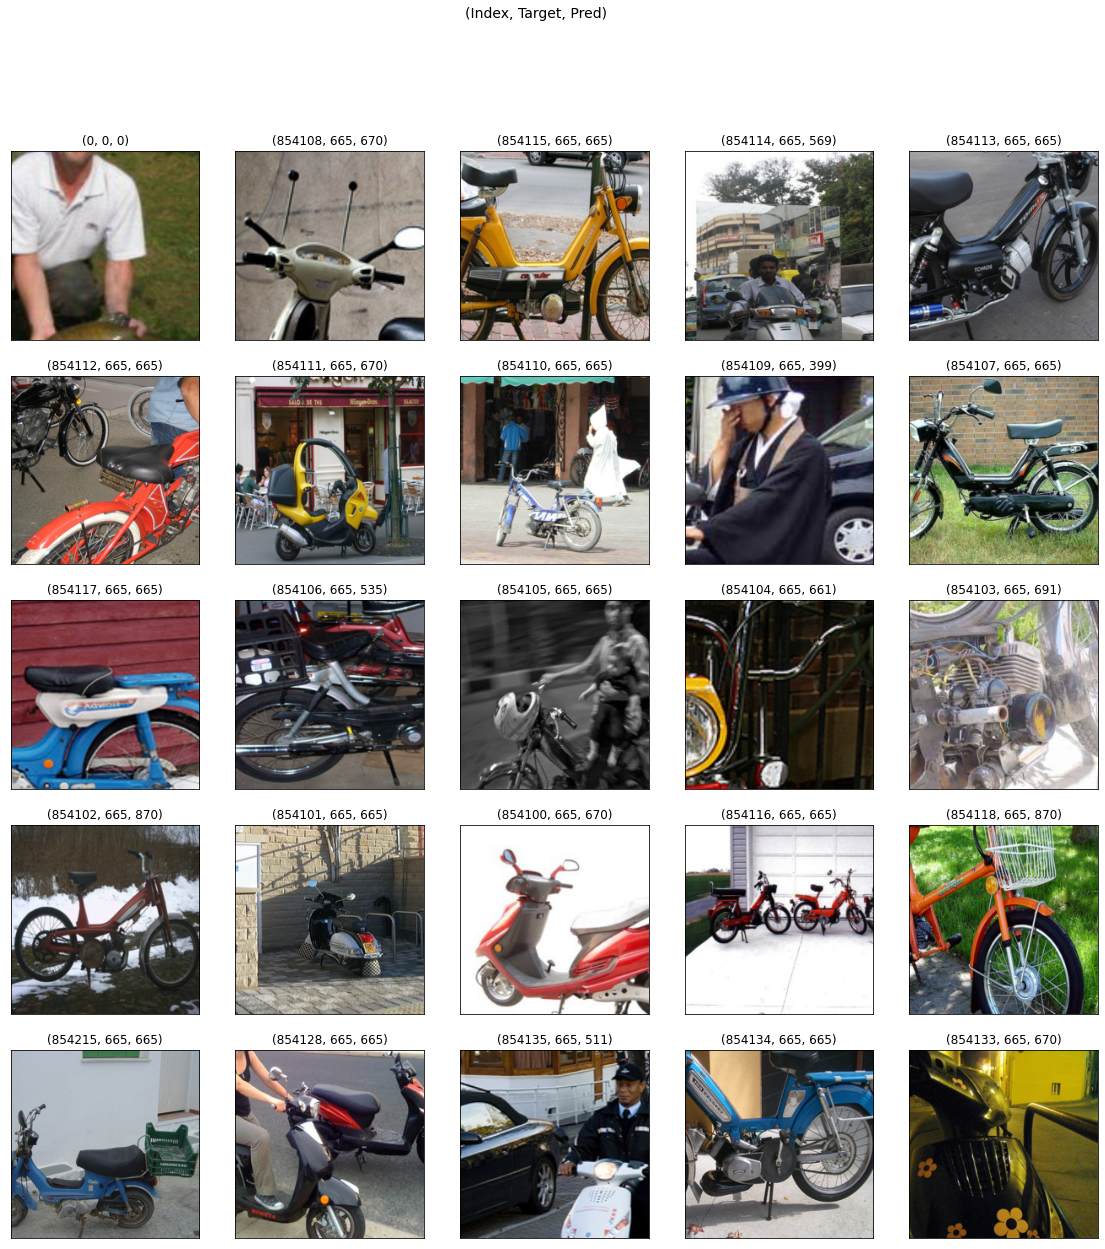

In [18]:
info = summary.plot_images_as_grid(
    datas,
    targets,
    preds,
    indices=v_ids,
    axes_pad=0.5,
    figsize=(20, 20),
    labels=idx2cls,
    caption_bottom=-0.1,
)

In [19]:
pd.DataFrame(info)

index  correct              target                         pred
0        0     True  tench, Tinca tinca           tench, Tinca tinca
1   854108    False               moped       motor scooter, scooter
2   854115     True               moped                        moped
3   854114    False               moped      garbage truck, dustcart
4   854113     True               moped                        moped
5   854112     True               moped                        moped
6   854111    False               moped       motor scooter, scooter
7   854110     True               moped                        moped
8   854109    False               moped                        abaya
9   854107     True               moped                        moped
10  854117     True               moped                        moped
11  854106    False               moped       disk brake, disc brake
12  854105     True               moped                        moped
13  854104    False               moped                      Model T
14  854103    False               moped                  oxygen mask
15  854102    False               moped  tricycle, trike, velocipede
16  854101     True               moped                        moped
17  854100    False               moped       motor scooter, scooter
18  854116     True               moped                        moped
19  854118    False               moped  tricycle, trike, velocipede
20  854215     True               moped                        moped
21  854128     True               moped                        moped
22  854135    False               moped                  convertible
23  854134     True               moped                        moped
24  854133    False               moped       motor scooter, scooter

---

##### a. Loss

In [20]:
l_ids = hist_loss["id"].tolist()[:topk]

**Model inference**

In [21]:
datas, targets = zip(*[train_dataset[id] for id in l_ids])
outputs = model(torch.stack(datas).to("cuda"))
preds = torch.argmax(outputs, axis=-1)

In [22]:
datas = [unnormalize(data) for data in datas]
datas = [torch.permute(data, (1, 2, 0)) for data in datas]
datas = [data.numpy() for data in datas]

**View plots**

In [23]:
hist_loss

trial  epoch       loss  visits  evict       id
804140       0     89  23.573599      90  False   804140
342405       0     89  20.377691      90  False   342405
1275167      0     89  20.201975      90  False  1275167
101426       0     89  20.159681      90  False   101426
1208598      0     89  19.530153      90  False  1208598
...        ...    ...        ...     ...    ...      ...
775751       0     89  -0.000000      90  False   775751
1093015      0     89  -0.000000      90  False  1093015
775768       0     89  -0.000000      90  False   775768
738147       0     89  -0.000000      90  False   738147
1176546      0     89  -0.000000      90  False  1176546

[1281167 rows x 6 columns]

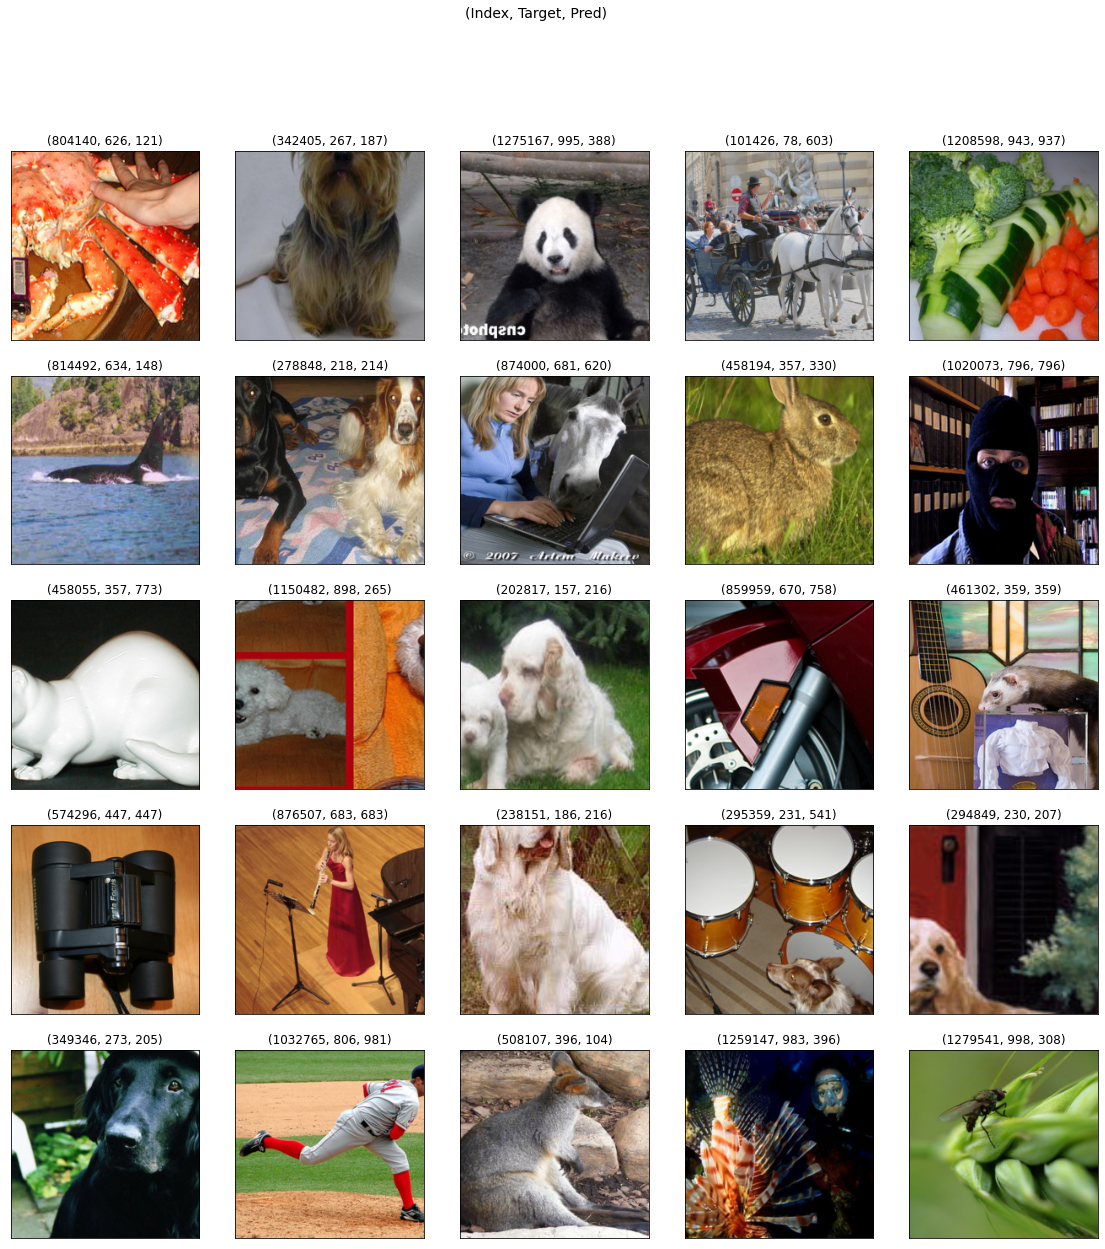

In [24]:
info = summary.plot_images_as_grid(
    datas,
    targets,
    preds,
    indices=l_ids,
    axes_pad=0.5,
    figsize=(20, 20),
    labels=idx2cls,
    caption_bottom=-0.1,
)

In [25]:
pd.DataFrame(info)

index  correct                                           target  \
0    804140    False                 lighter, light, igniter, ignitor   
1    342405    False                                  standard poodle   
2   1275167    False                                        earthstar   
3    101426    False                                             tick   
4   1208598    False                                   cucumber, cuke   
5    814492    False                              lumbermill, sawmill   
6    278848    False                           Welsh springer spaniel   
7    874000    False                      notebook, notebook computer   
8    458194    False                                             mink   
9   1020073     True                                         ski mask   
10   458055    False                                             mink   
11  1150482    False                                     water bottle   
12   202817    False                                         papillon   
13   859959    False                           motor scooter, scooter   
14   461302     True    black-footed ferret, ferret, Mustela nigripes   
15   574296     True         binoculars, field glasses, opera glasses   
16   876507     True                          oboe, hautboy, hautbois   
17   238151    False                                  Norwich terrier   
18   295359    False                                           collie   
19   294849    False  Shetland sheepdog, Shetland sheep dog, Shetland   
20   349346    False           dingo, warrigal, warragal, Canis dingo   
21  1032765    False                                             sock   
22   508107    False                                         lionfish   
23  1259147    False                                      scuba diver   
24  1279541    False                            ear, spike, capitulum   

                                                 pred  
0   king crab, Alaska crab, Alaskan king crab, Ala...  
1                                   Yorkshire terrier  
2   giant panda, panda, panda bear, coon bear, Ail...  
3                              horse cart, horse-cart  
4                                            broccoli  
5   killer whale, killer, orca, grampus, sea wolf,...  
6                                       Gordon setter  
7                             laptop, laptop computer  
8          wood rabbit, cottontail, cottontail rabbit  
9                                            ski mask  
10                            saltshaker, salt shaker  
11                                         toy poodle  
12                           clumber, clumber spaniel  
13                                               reel  
14      black-footed ferret, ferret, Mustela nigripes  
15           binoculars, field glasses, opera glasses  
16                            oboe, hautboy, hautbois  
17                           clumber, clumber spaniel  
18                        drum, membranophone, tympan  
19                                   golden retriever  
20                              flat-coated retriever  
21                        ballplayer, baseball player  
22                            wallaby, brush kangaroo  
23                                           lionfish  
24                                                fly

### B. Test

In [26]:
arg_file = "args.json"
csv_file = "test_cache_map.csv"
model_file = "model.pth"

In [27]:
test_dataset = datasets.ImageFolder(
    "imagenet/val",
    transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ]
    ),
)

#### i. Load data

In [28]:
hist_paths = summary.get_paths(csv_file, dataset, experiment_name)
arg_paths = summary.get_paths(arg_file, dataset, experiment_name)
model_paths = summary.get_paths(model_file, dataset, experiment_name)

In [29]:
hist_path = hist_paths[index]
arg_path = arg_paths[index]
model_path = model_paths[index]

In [30]:
hist = pd.read_csv(hist_path)
arg = summary.json_load(arg_path)
model = torch.load(model_path)

In [31]:
hist_visits = hist.sort_values(by=["visits"], ascending=False)
hist_loss = hist.sort_values(by=["loss"], ascending=False)

In [32]:
print(arg)

{'dataset': 'imagenet', 'arch': 'resnet18', 'train_kwargs': {'batch_size': 256, 'sampler': True, 'steps': 1, 'shuffle': True}, 'test_kwargs': {'batch_size': 256, 'sampler': True, 'steps': 1, 'shuffle': False}, 'n_trials': 1, 'epochs': 90, 'lr': 0.1, 'gamma': 0.1, 'momentum': 0.9, 'weight_decay': 0.0001, 'pretrained': False, 'no_cuda': False, 'num_workers': 6, 'seed': 1431655765, 'save_dir': 'results', 'device': 'cuda'}


#### ii. View tables

> `Visits` are meaningless during model evaluation, so only the images with the largest loss are shown below.

##### a. Loss

In [33]:
l_ids = hist_loss["id"].tolist()[:topk]

**Model inference**

In [34]:
datas, targets = zip(*[test_dataset[id] for id in l_ids])
outputs = model(torch.stack(datas).to("cuda"))
preds = torch.argmax(outputs, axis=-1)

In [35]:
datas = [unnormalize(data) for data in datas]
datas = [torch.permute(data, (1, 2, 0)) for data in datas]
datas = [data.numpy() for data in datas]

**View plots**

In [36]:
hist_loss

trial  epoch       loss  visits  evict     id
23158      0     89  25.186481      90  False  23158
20689      0     89  20.327744      90  False  20689
8527       0     89  18.999084      90  False   8527
35029      0     89  18.839657      90  False  35029
29148      0     89  18.300529      90  False  29148
...      ...    ...        ...     ...    ...    ...
30226      0     89  -0.000000      90  False  30226
30246      0     89  -0.000000      90  False  30246
30247      0     89  -0.000000      90  False  30247
37497      0     89  -0.000000      90  False  37497
29712      0     89  -0.000000      90  False  29712

[50000 rows x 6 columns]

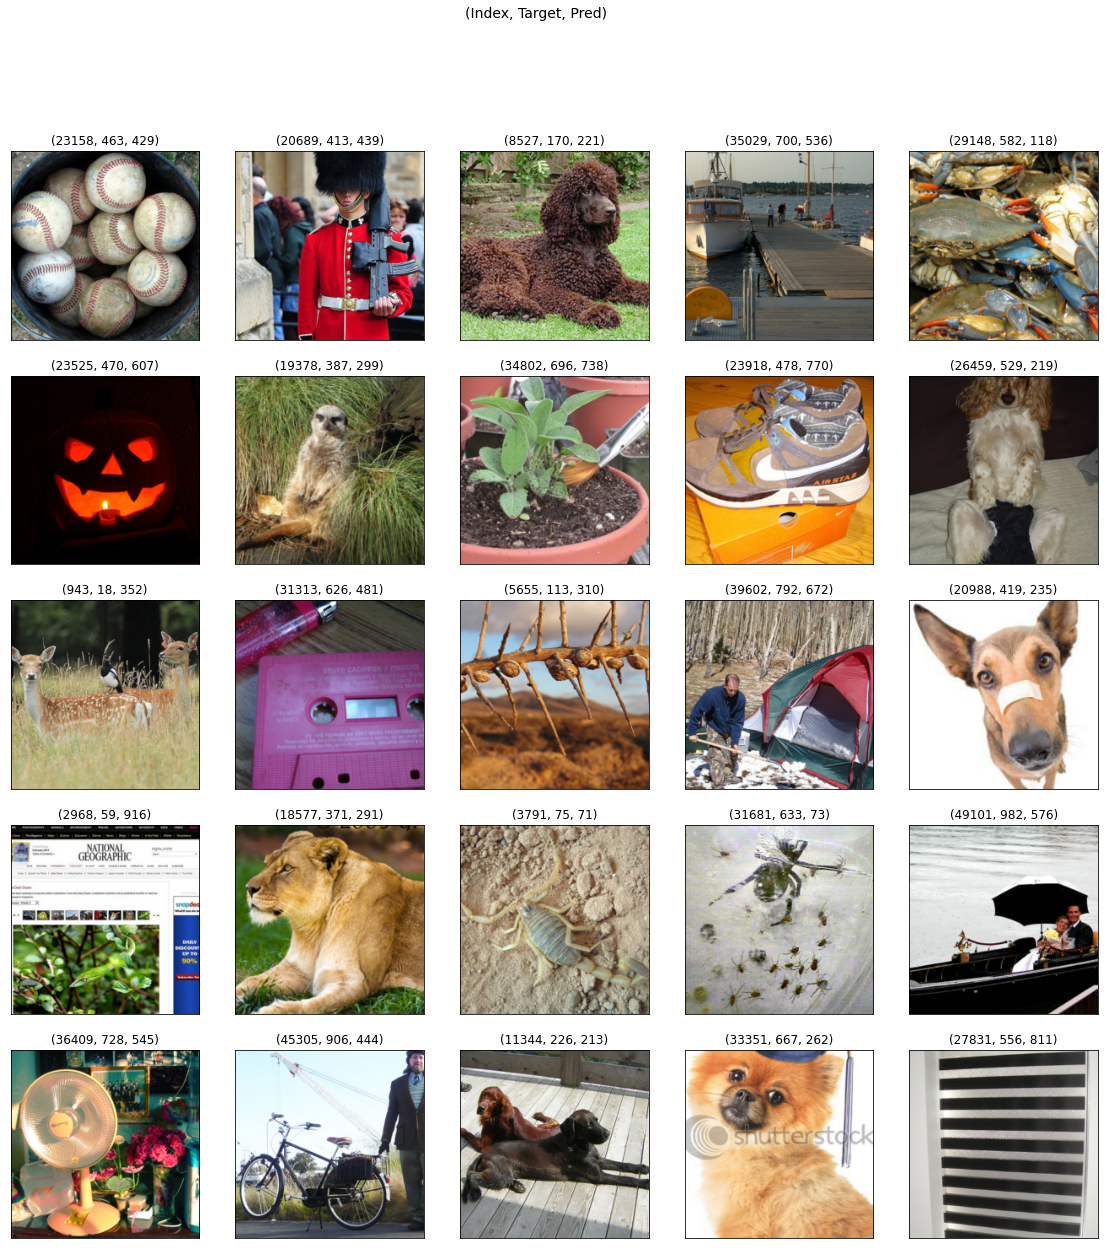

In [37]:
info = summary.plot_images_as_grid(
    datas,
    targets,
    preds,
    indices=l_ids,
    axes_pad=0.5,
    figsize=(20, 20),
    labels=idx2cls,
    caption_bottom=-0.1,
)

In [38]:
pd.DataFrame(info)

index  correct                                             target  \
0   23158    False                                       bucket, pail   
1   20689    False                         assault rifle, assault gun   
2    8527    False                                    Irish wolfhound   
3   35029    False                                        paper towel   
4   29148    False        grocery store, grocery, food market, market   
5   23525    False                           candle, taper, wax light   
6   19378    False  lesser panda, red panda, panda, bear cat, cat ...   
7   34802    False                                         paintbrush   
8   23918    False                                             carton   
9   26459    False                              diaper, nappy, napkin   
10    943    False                                             magpie   
11  31313    False                   lighter, light, igniter, ignitor   
12   5655    False                                              snail   
13  39602    False                                             shovel   
14  20988    False                                           Band Aid   
15   2968    False                                         vine snake   
16  18577    False           patas, hussar monkey, Erythrocebus patas   
17   3791    False                   black widow, Latrodectus mactans   
18  31681    False                             loupe, jeweler's loupe   
19  49101    False                                  groom, bridegroom   
20  36409    False                                        plastic bag   
21  45305    False                                        Windsor tie   
22  11344    False                                             briard   
23  33351    False                                        mortarboard   
24  27831    False                             fire screen, fireguard   

                                                 pred  
0                                            baseball  
1                              bearskin, busby, shako  
2                                 Irish water spaniel  
3                     dock, dockage, docking facility  
4                     Dungeness crab, Cancer magister  
5                                     jack-o'-lantern  
6                                    meerkat, mierkat  
7                                      pot, flowerpot  
8                                        running shoe  
9      cocker spaniel, English cocker spaniel, cocker  
10                         impala, Aepyceros melampus  
11                                           cassette  
12                                ant, emmet, pismire  
13                                      mountain tent  
14  German shepherd, German shepherd dog, German p...  
15             web site, website, internet site, site  
16                 lion, king of beasts, Panthera leo  
17                                           scorpion  
18                     barn spider, Araneus cavaticus  
19                                            gondola  
20                               electric fan, blower  
21      bicycle-built-for-two, tandem bicycle, tandem  
22                           Irish setter, red setter  
23                                  Brabancon griffon  
24                                       space heater

---

* When loss is significantly large, the data is most likely incorrectly labeled.
* Most of the model performance gains comes from correctly classifying the small loss cases